## Summary
*   This project builds a basic popularity based recommendation system, and an alternating least square (ALS) matrix factorization recommendation system implemented with Spark ML.
*   The ALS model was trainined on the MovieLens **27,000,000** movie rating dataset. Best model achieved RMSE of **0.40**.
*   Trained model can predict each user's rating to all the movies in the database. So for each user, the recommendation system can recommend movies he/she is likely to like.
*   Also the item matrix can be used to find similar movies for each movie. When user is browsing for certain movies, similar movies can be recommended to him/her.

## Process
1. Data exploration to have an overall understanding of the dataset.
2. Popularity based recommendation and evaluation using mean average precision, precision@k and NDCG@k.
3. Trian a ALS model, and tune hyperparameter using cross validation. Model evaluation use RMSE, mean average precision, precision@k and NDCG@k.
4. Use the trained model to recommend movies to user(s). Use item matrix to recommend similar movies of a specific movie.


In [1]:
# Install dependencies of Spark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz 
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:15 http

In [2]:
# Install Spark
!pip install -q findspark
!pip install py4j

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"
import findspark
findspark.init("spark-3.0.1-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

     |████████████████████████████████| 204kB 9.0MB/s 
/bin/bash: /usr/lib/jvm/java-8-openjdk-amd64: Is a directory



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("RecSys_ALS") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
!pip install 'PyArrow==0.15.1'
!pip install koalas

     |████████████████████████████████| 59.2MB 63kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 675kB 9.0MB/s 


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import math
import databricks.koalas as ks
%matplotlib inline
import os
os.environ["PYSPARK_PYTHON"] = "python3"

In [6]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import RankingEvaluator

# Part 0: Data ETL and Data Exploration


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
movies_df = spark.read.load("drive/My Drive/Colab notebooks/movieRec/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("drive/My Drive/Colab notebooks/movieRec/ratings.csv", format='csv', header = True)

In [64]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [10]:
ratings_df.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    307|   3.5|1256677221|
|     1|    481|   3.5|1256677456|
|     1|   1091|   1.5|1256677471|
|     1|   1257|   4.5|1256677460|
|     1|   1449|   4.5|1256677264|
+------+-------+------+----------+
only showing top 5 rows



# Part 1: Spark SQL and OLAP

In [11]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")

## Q1: The number of Users

In [12]:
number_of_users = spark.sql("""
select count(distinct userid) as Number_of_users 
from ratings
""")
number_of_users.show()

+---------------+
|Number_of_users|
+---------------+
|         283228|
+---------------+



## Q2: The number of Movies

In [13]:
number_of_movies = spark.sql("""
select count(distinct movieid) as Number_of_movies
from movies
""")
number_of_movies.show()

+----------------+
|Number_of_movies|
+----------------+
|           58098|
+----------------+



## Q3:  How many movies are rated by users? How many movies are not rated by any users? List movies not rated by any user

In [14]:
%%time
number_of_movies_rated = spark.sql("""
select count(distinct movieid) as Number_of_movies_rated
from ratings
""")
number_of_movies_rated.show()

+----------------------+
|Number_of_movies_rated|
+----------------------+
|                 53889|
+----------------------+

CPU times: user 6.19 ms, sys: 985 µs, total: 7.18 ms
Wall time: 33.2 s


In [15]:
%%time
number_of_movies_not_rated = spark.sql("""
select count(distinct a.movieid)
from movies a left join ratings b on a.movieid = b.movieid
where b.movieid is Null
""")
number_of_movies_not_rated.show()

+-----------------------+
|count(DISTINCT movieid)|
+-----------------------+
|                   4209|
+-----------------------+

CPU times: user 10.2 ms, sys: 3.25 ms, total: 13.5 ms
Wall time: 1min 3s


In [16]:
%%time
movies_not_rated = spark.sql("""
select a.movieid, a.title, a.genres
from movies a left join ratings b on a.movieid = b.movieid
where b.movieid is Null
""")
movies_not_rated.show()

+-------+--------------------+--------------------+
|movieid|               title|              genres|
+-------+--------------------+--------------------+
| 135352|Heroes of the Wes...|  (no genres listed)|
| 135901|Count the Hours (...|               Crime|
| 138076|Diary of a Tired ...|Comedy|Drama|Romance|
| 145275|   Live Wires (1946)|     Action|Thriller|
| 151859|Hart to Hart Retu...|Adventure|Crime|M...|
| 156821|       Yakeen (1969)|Action|Crime|Myst...|
| 159526|Black Cobra Woman...|        Drama|Horror|
| 163288|Those Three Frenc...|  (no genres listed)|
| 165977|Behind the Make-U...|               Drama|
| 174251|     The Cure (1924)|    Animation|Comedy|
| 116060|Code Name: Emeral...|    Action|Drama|War|
| 117742|     The Fake (1953)|         Crime|Drama|
| 123069|Midnight Heat (1996)|Action|Drama|Thri...|
| 125469|Till the End of T...|       Drama|Romance|
| 132802|Nest of Vipers (1...|       Drama|Romance|
| 133189|To Kill A Clown (...|      Drama|Thriller|
| 136782|The

## Q4:  Number of ratings per movie: min, max, distribution

In [17]:
number_of_ratings_per_movie = ratings_df.groupBy("movieId").count().toPandas()

print('For the movies that have been rated:')
print('Minimum number of ratings per movie is {}'.format(number_of_ratings_per_movie['count'].min()))
print('Maximum number of ratings per movie is {}'.format(number_of_ratings_per_movie['count'].max()))

For the movies that have been rated:
Minimum number of ratings per movie is 1
Maximum number of ratings per movie is 97999


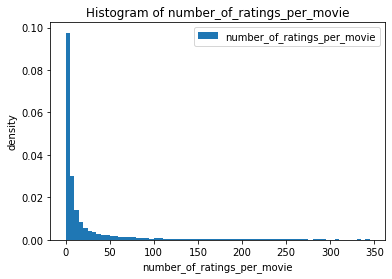

In [18]:
plt.hist(number_of_ratings_per_movie['count'], bins=range(0, 350, 5), 
         label = 'number_of_ratings_per_movie', density = True)
plt.title('Histogram of number_of_ratings_per_movie')
plt.legend(loc='upper right')
plt.xlabel('number_of_ratings_per_movie')
plt.ylabel('density')
plt.show()

In [20]:
tmp1 = number_of_ratings_per_movie[number_of_ratings_per_movie['count'] == 1].shape[0]
print('{} percent movies are rated once'.format(tmp1/number_of_movies.first()[0] * 100))

17.479087059795518 percent movies are rated once


list top 20 movies received the highest numer of rating, number_of_ratings, and avg_rating

In [21]:
%%time
highest_number_of_ratings_per_movie = spark.sql("""
select a.movieid, a.title, a.genres, b.number_of_ratings, b.avg_rating
from movies a
join
(select movieid, count(*) as number_of_ratings, avg(rating) as avg_rating
from ratings
group by movieid
order by number_of_ratings desc
limit 20) b on a.movieid = b.movieid
order by number_of_ratings desc
""")
highest_number_of_ratings_per_movie.show()

+-------+--------------------+--------------------+-----------------+------------------+
|movieid|               title|              genres|number_of_ratings|        avg_rating|
+-------+--------------------+--------------------+-----------------+------------------+
|    318|Shawshank Redempt...|         Crime|Drama|            97999| 4.424188001918387|
|    356| Forrest Gump (1994)|Comedy|Drama|Roma...|            97040| 4.056584913437757|
|    296| Pulp Fiction (1994)|Comedy|Crime|Dram...|            92406| 4.173971387139363|
|    593|Silence of the La...|Crime|Horror|Thri...|            87899|  4.15141241652351|
|   2571|  Matrix, The (1999)|Action|Sci-Fi|Thr...|            84545| 4.149695428470046|
|    260|Star Wars: Episod...|Action|Adventure|...|            81815| 4.120454684348836|
|    480|Jurassic Park (1993)|Action|Adventure|...|            76451|3.6650338125073576|
|    527|Schindler's List ...|           Drama|War|            71516| 4.257501817775044|
|    110|   Bravehear

## Q5:  Number of ratings per user: min, max, distribution

In [22]:
number_of_ratings_per_user = ratings_df.groupBy("userId").count().toPandas()

print('For users that have rated movie:')
print('Minimum number of ratings per user is {}'.format(number_of_ratings_per_user['count'].min()))
print('Maximum number of ratings per user is {}'.format(number_of_ratings_per_user['count'].max()))

For users that have rated movie:
Minimum number of ratings per user is 1
Maximum number of ratings per user is 23715


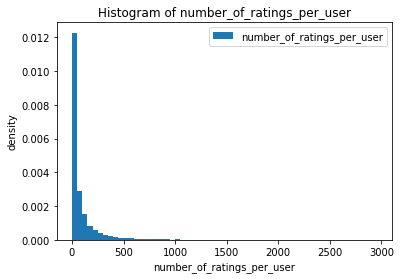

In [23]:
plt.hist(number_of_ratings_per_user['count'], bins=range(0, 3000, 50), 
         label = 'number_of_ratings_per_user', density = True)
plt.title('Histogram of number_of_ratings_per_user')
plt.legend(loc='upper right')
plt.xlabel('number_of_ratings_per_user')
plt.ylabel('density')
plt.show()

list top 20 users gave the highest numer of rating, number_of_ratings, and avg_rating

In [24]:
%%time
highest_number_of_ratings_per_user = spark.sql("""
select userid, count(*) as number_of_ratings, avg(rating) as avg_rating
from ratings
group by userid
order by number_of_ratings desc
limit 20
""")
highest_number_of_ratings_per_user.show()

+------+-----------------+------------------+
|userid|number_of_ratings|        avg_rating|
+------+-----------------+------------------+
|123100|            23715|3.1306346194391734|
|117490|             9279|3.2784243991809463|
|134596|             8381| 3.198305691444935|
|212343|             7884|2.5880263825469303|
|242683|             7515|3.2083166999334662|
|111908|             6645|1.5249811888638074|
| 77609|             6398|2.8122069396686467|
| 63783|             6346|3.4854238890639775|
|172357|             5868| 2.442058623040218|
|141955|             5810|2.8747848537005165|
|158002|             5701|3.7478512541659357|
|253511|             5356| 3.011669156086632|
| 48470|             5257| 2.472988396423816|
|183233|             5169|2.4049139098471657|
| 94843|             5130|1.1253411306042884|
| 73145|             5042|2.9775882586275286|
| 37046|             5041| 3.214243205713152|
|187986|             4951|3.2057160169662695|
|  4796|             4874|3.040418

## Q6: Distribution of ratings

In [25]:
number_per_rating = ratings_df.groupBy("rating").count().toPandas()

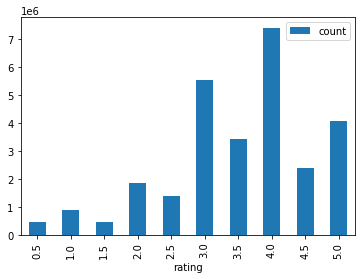

In [26]:
number_per_rating.sort_values(by='rating').plot.bar(x='rating', y='count')

## Q7: List distinct genres

In [27]:
genres = spark.sql("""
select distinct genres
from movies
""")
genres.show()

+--------------------+
|              genres|
+--------------------+
|Comedy|Horror|Thr...|
|Adventure|Sci-Fi|...|
|Action|Adventure|...|
| Action|Drama|Horror|
|Comedy|Drama|Horr...|
|Action|Animation|...|
|Fantasy|Musical|M...|
|Adventure|Mystery...|
|Children|Comedy|D...|
|Action|Adventure|...|
|Animation|Childre...|
|Action|Adventure|...|
| Adventure|Animation|
|    Adventure|Sci-Fi|
|Documentary|Music...|
|  Documentary|Sci-Fi|
|Adventure|Childre...|
|Action|Adventure|...|
|Comedy|Drama|Fant...|
| Musical|Romance|War|
+--------------------+
only showing top 20 rows



In [28]:
genres_splitted =  spark.sql("""
select distinct explode(split(genres, '[|]')) as Genre
from movies
order by 1
""")

print('In total there are {} different genres'.format(genres_splitted.count()))
genres_splitted.show()

In total there are 20 different genres
+------------------+
|             Genre|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



## Q8: Genre for each movie

In [29]:
%%time
movie_genre = spark.sql("""
select movieid, explode(split(genres, '[|]')) as Genre
from movies
""")
movie_genre.show()

+-------+---------+
|movieid|    Genre|
+-------+---------+
|      1|Adventure|
|      1|Animation|
|      1| Children|
|      1|   Comedy|
|      1|  Fantasy|
|      2|Adventure|
|      2| Children|
|      2|  Fantasy|
|      3|   Comedy|
|      3|  Romance|
|      4|   Comedy|
|      4|    Drama|
|      4|  Romance|
|      5|   Comedy|
|      6|   Action|
|      6|    Crime|
|      6| Thriller|
|      7|   Comedy|
|      7|  Romance|
|      8|Adventure|
+-------+---------+
only showing top 20 rows

CPU times: user 1.58 ms, sys: 0 ns, total: 1.58 ms
Wall time: 122 ms


In [30]:
number_per_genre =  spark.sql("""
select Genre, count(*) as number
from (select movieid, explode(split(genres, '[|]')) as Genre from movies)
group by 1
order by 1
""")
number_per_genre.show()

+------------------+------+
|             Genre|number|
+------------------+------+
|(no genres listed)|  4266|
|            Action|  7130|
|         Adventure|  4067|
|         Animation|  2663|
|          Children|  2749|
|            Comedy| 15956|
|             Crime|  5105|
|       Documentary|  5118|
|             Drama| 24144|
|           Fantasy|  2637|
|         Film-Noir|   364|
|            Horror|  5555|
|              IMAX|   197|
|           Musical|  1113|
|           Mystery|  2773|
|           Romance|  7412|
|            Sci-Fi|  3444|
|          Thriller|  8216|
|               War|  1820|
|           Western|  1378|
+------------------+------+



In [31]:
list_of_movies =  spark.sql("""
select Genre, concat_ws(',', collect_set(title)) as list_of_movies
from (select title, explode(split(genres, '[|]')) as Genre from movies)
group by 1
""")
list_of_movies.show()

+------------------+--------------------+
|             Genre|      list_of_movies|
+------------------+--------------------+
|             Crime|Hot Rock, The (19...|
|           Romance|Brain Drain (2009...|
|          Thriller|The Sleeper (2012...|
|         Adventure|Masters of the Un...|
|             Drama|My Life (1993),Al...|
|               War|PT 109 (1963),Sol...|
|       Documentary|U2: Rattle and Hu...|
|           Fantasy|Masters of the Un...|
|           Mystery|Manila in the Cla...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Bugs in Love (193...|
|         Film-Noir|Thieves' Highway ...|
|(no genres listed)|The Youth of Maxi...|
|              IMAX|Harry Potter and ...|
|            Horror|The Sleeper (2012...|
|           Western|The Maverick Quee...|
|            Comedy|The Sleeper (2012...|
|          Children|Home on the Range...|
|            Action|Masters of the Un...|
|            Sci-Fi|Mosquito (1995),S...|
+------------------+--------------

# Part 2: Popularity based recommendation and evaluation

In [32]:
# Data type convert
movie_ratings_df = ratings_df.withColumn('userId', ratings_df['userId'].cast(DoubleType())) \
  .withColumn('movieId', ratings_df['movieId'].cast(DoubleType())) \
  .withColumn('rating', ratings_df['rating'].cast(FloatType())) \

movie_ratings_df = movie_ratings_df.withColumn('ratingBinary', when(movie_ratings_df['rating'] >= 3.5, 1).otherwise(0)) \
  .drop('timestamp')

In [33]:
movie_ratings_df.registerTempTable("movie_ratings")

In [34]:
# ground truth labels
labels = movie_ratings_df.filter(movie_ratings_df['ratingBinary'] == 1) \
  .groupBy('userId').agg(collect_list(movie_ratings_df['movieId']).alias('ground_truth'))

In [35]:
labels.show()

+------+--------------------+
|userId|        ground_truth|
+------+--------------------+
| 299.0|[6.0, 50.0, 110.0...|
| 305.0|[4993.0, 5952.0, ...|
| 496.0|[3.0, 110.0, 144....|
| 558.0|[25.0, 32.0, 36.0...|
| 596.0|[296.0, 318.0, 85...|
| 692.0|[47.0, 318.0, 356...|
| 769.0|[110.0, 161.0, 16...|
| 934.0|[47.0, 110.0, 296...|
|1051.0|[1.0, 2.0, 3.0, 7...|
|1761.0|[4439.0, 5618.0, ...|
|2734.0|[50.0, 428.0, 108...|
|2815.0|            [2023.0]|
|2862.0|[491.0, 534.0, 95...|
|3597.0|[1.0, 7.0, 10.0, ...|
|3901.0|[593.0, 1136.0, 1...|
|3980.0|[145.0, 673.0, 14...|
|4066.0|[785.0, 1092.0, 1...|
|4142.0|[50.0, 85.0, 111....|
|4800.0|[527.0, 902.0, 90...|
|5360.0|[296.0, 608.0, 77...|
+------+--------------------+
only showing top 20 rows



In [36]:
def pupularity_based_recommendation_and_evaluation(topk, min_num_rating=50):
  # count number of rating, and calculate average rating for each movie
  movie_with_avg_ratings_df = movie_ratings_df.groupBy('movieId') \
    .agg(count(movie_ratings_df['ratingBinary']).alias('count'), avg(movie_ratings_df['ratingBinary']).alias('average'))

  # filter movies with at least min_num_rating ratings, take top k highest average rating to recommend
  topk_to_recommend = movie_with_avg_ratings_df.filter(movie_with_avg_ratings_df['count']>min_num_rating) \
    .orderBy(desc('average')) \
    .limit(topk) \
    .agg(collect_list('movieId')).collect()[0][0]
  print('topk movies to recommend: ', topk_to_recommend)

  # dataframe with groud truth labels and topk to recommend
  labels_and_topk_pop_to_recommend = labels.withColumn('topk', array([lit(i) for i in topk_to_recommend]))

  topk_evaluator = RankingEvaluator(predictionCol='topk', labelCol='ground_truth')
  # default MAP
  print('MAP:', topk_evaluator.evaluate(labels_and_topk_pop_to_recommend))
  precision_at_k = topk_evaluator.evaluate(labels_and_topk_pop_to_recommend, 
                                           {topk_evaluator.metricName: "precisionAtK", topk_evaluator.k: 20})
  ndcg_at_k = topk_evaluator.evaluate(labels_and_topk_pop_to_recommend, 
                                      {topk_evaluator.metricName: "ndcgAtK", topk_evaluator.k: 20})
  
  print('precison_at_k: ', precision_at_k)
  print('ndcg_at_k: ', ndcg_at_k)

In [37]:
pupularity_based_recommendation_and_evaluation(topk = 20)

topk movies to recommend:  [183423.0, 172591.0, 171011.0, 174053.0, 170705.0, 159817.0, 26596.0, 318.0, 90592.0, 44555.0, 138835.0, 185135.0, 169906.0, 166024.0, 147286.0, 106165.0, 143511.0, 172577.0, 121374.0, 6016.0]
MAP: 0.0018451835759297891
precison_at_k:  0.02213292610004905
ndcg_at_k:  0.021383863212357062


# Part3: ALS Model Recommendation and Evaluation

## ALS Model 

In [38]:
#Create test and train set
(training,test)=movie_ratings_df.randomSplit([0.8,0.2], seed = 42)

In [39]:
#Create default ALS model
als = ALS(userCol='userId', itemCol='movieId', ratingCol='ratingBinary', coldStartStrategy='drop', seed=42)

In [40]:
%%time
#Fit ALS model to training data
alsModel = als.fit(training)

CPU times: user 51.2 ms, sys: 7.04 ms, total: 58.2 ms
Wall time: 3min 53s


In [41]:
# Define evaluator as RMSE
rmseEvaluator = RegressionEvaluator(metricName='rmse', predictionCol='prediction', labelCol='ratingBinary')

In [42]:
#Generate predictions and evaluate using RMSE
predictions=alsModel.transform(test)
rmse = rmseEvaluator.evaluate(predictions)
print('rmse: ', rmse)

rmse:  0.42582218883226175


In [43]:
def format_recommendations(recommendations):
    # From recommendations column extract only items
    # recommended and ignore ratings
    recommended_movies = [float(row.movieId) for row in recommendations]
    return recommended_movies

def model_evaluation(model, topk):
  modelRecommendations = model.recommendForAllUsers(topk)

  udf_format_recommendations = udf(lambda x: format_recommendations(x), ArrayType(DoubleType()))

  modelRecommendations = modelRecommendations \
    .withColumn('recommendations', udf_format_recommendations(modelRecommendations['recommendations'])) \
    .withColumn('userId', modelRecommendations['userId'].cast(DoubleType()))

  modelRecommendations_and_labels = modelRecommendations.join(labels, 'userId', 'inner')

  evaluator = RankingEvaluator(predictionCol='recommendations', labelCol='ground_truth')
  # default MAP
  print('MAP: ', evaluator.evaluate(modelRecommendations_and_labels))
  precision_at_k = evaluator.evaluate(modelRecommendations_and_labels, {evaluator.metricName: "precisionAtK", evaluator.k: 20})
  ndcg_at_k = evaluator.evaluate(modelRecommendations_and_labels, {evaluator.metricName: "ndcgAtK", evaluator.k: 20})
  print('precison_at_k: ', precision_at_k)
  print('ndcg_at_k: ', ndcg_at_k)


In [44]:
%%time
model_evaluation(alsModel, topk=20)

MAP:  5.294417754046425e-05
precison_at_k:  4.186235370634549e-05
ndcg_at_k:  0.00010677402597627779
CPU times: user 577 ms, sys: 113 ms, total: 691 ms
Wall time: 55min 7s


## Cross Validation and Hyperparameter Search

In [45]:
#Tune model using ParamGridBuilder
paramGrid = (ParamGridBuilder()
            .addGrid(als.rank, [10, 20])
            .addGrid(als.maxIter, [5, 10])
            .addGrid(als.regParam, [0.05, 0.1])
            .build())

In [46]:
# Build Cross validation 
cv = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=rmseEvaluator, numFolds=5, seed=42)

In [47]:
%%time
#Fit to training data
cvModel = cv.fit(training)

CPU times: user 8.16 s, sys: 1.24 s, total: 9.39 s
Wall time: 2h 10min 18s


In [81]:
#Extract best model from the tuning exercise using ParamGridBuilder
best_model = cvModel.bestModel

In [49]:
# save best_model
"""
best_model.save('best_model')
best_model = ALSModel.load('best_model')
"""

In [82]:
#Print best model parameters
print ("**Best Model**")
print (" Rank:", best_model._java_obj.parent().getRank())
print (" MaxIter:", best_model._java_obj.parent().getMaxIter()) 
print (" RegParam:", best_model._java_obj.parent().getRegParam())

**Best Model**
 Rank: 20
 MaxIter: 10
 RegParam: 0.05


In [51]:
#Generate predictions and evaluate using RMSE
predictions_best = best_model.transform(test)
rmse_best = rmseEvaluator.evaluate(predictions_best)
print('Best model rmse is : ', rmse_best)

Best model rmse is :  0.40426763508021385


In [52]:
model_evaluation(best_model, topk=20)

MAP:  0.00018348137816268323
precison_at_k:  0.0002438077853197889
ndcg_at_k:  0.0005179361173493833


In [53]:
predictions_all=best_model.transform(movie_ratings_df)
predictions_all_movies = predictions_all.join(movies_df.withColumn('movieId', movies_df['movieId'].cast(DoubleType())),
                                             'movieId', 'left')

In [54]:
predictions_all_movies.show(truncate=False)

+-------+------+------+------------+-----------+---------------------------------------------------------------+-------------------------------------------+
|movieId|userId|rating|ratingBinary|prediction |title                                                          |genres                                     |
+-------+------+------+------------+-----------+---------------------------------------------------------------+-------------------------------------------+
|1.0    |148.0 |4.0   |1           |0.5193709  |Toy Story (1995)                                               |Adventure|Animation|Children|Comedy|Fantasy|
|3.0    |148.0 |3.0   |0           |0.012080308|Grumpier Old Men (1995)                                        |Comedy|Romance                             |
|5.0    |148.0 |2.0   |0           |0.020898728|Father of the Bride Part II (1995)                             |Comedy                                     |
|7.0    |148.0 |3.0   |0           |0.18209212 |Sabrina (1

# Part4: ALS model application

## Recommend movie to users with id: 575, 232

In [55]:
userSubset = predictions_all.filter((predictions_all['userId'] == 575.0) | (predictions_all['userId'] == 232.0))

In [56]:
%%time
movie_recommendation_for_subset = best_model.recommendForUserSubset(userSubset, 10)
movie_recommendation_for_subset.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   232|[[151957, 1.37705...|
|   575|[[125928, 1.28529...|
+------+--------------------+

CPU times: user 45.2 ms, sys: 8.08 ms, total: 53.3 ms
Wall time: 50.4 s


In [57]:
movie_recommendation_for_subset = movie_recommendation_for_subset \
  .select('userId', explode('recommendations').alias('recommendations'))

movie_recommendation_for_subset = movie_recommendation_for_subset.select('userId', 'recommendations.*')

movie_recommendation_for_subset = movie_recommendation_for_subset.join(movies_df,'movieId', 'left')

movie_recommendation_for_subset.show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
| 151957|   232|1.3770527|    Amerikana (2001)|  (no genres listed)|
| 149542|   232|1.3770527|  The Doe Boy (2001)|       Drama|Romance|
| 179653|   232|1.3619199|         Bwoy (2016)|               Drama|
| 123653|   232|1.3302215|Salem Witch Trial...|               Drama|
| 171997|   232|1.3013844|The Last of the B...|              Comedy|
| 139974|   232|1.2803034|Cari fottutissimi...|              Comedy|
| 173153|   232|1.2704713|Heroes Shed No Te...|              Action|
| 154512|   232|1.2704713|The Legend of Sle...|Drama|Fantasy|Hor...|
| 166299|   232|1.2666631| Stormy Night (2005)|           Animation|
| 138460|   232|1.2505876|The Man Who Will ...|               Drama|
| 125928|   575|1.2852939|Santa's Pocket Wa...|  (no genres listed)|
| 186951|   575|1.0940729|        

## Find the similar moives for moive with id: 463, 471, 2
Find the similar moives based on the item matrix

In [58]:
items_kdf = best_model.itemFactors.to_koalas()
items_kdf.head(10)

,id,features
0,9,"[0.2593343257904053, -0.08401418477296829, -0...."
1,19,"[0.24700193107128143, -0.11901696026325226, 0...."
2,29,"[-0.21504580974578857, 0.19818761944770813, -0..."
3,39,"[-0.03504638001322746, 0.32929733395576477, -0..."
4,49,"[0.02052043192088604, 0.38534772396087646, -0...."
5,59,"[-0.25584128499031067, 0.23795901238918304, -0..."
6,69,"[0.05400983989238739, -0.07589375227689743, 0...."
7,79,"[0.23537787795066833, -0.039434369653463364, -..."
8,89,"[0.1862737238407135, 0.0391068235039711, -0.05..."
9,99,"[-0.06767033785581589, 0.17364485561847687, -0..."


In [59]:
def top10_similar(targetId):
  try:
    target_feature = items_kdf[items_kdf.id == str(targetId)]['features'].to_numpy()[0]
  except:
    return 'movie ' + str(targetId) + ' is not found'

  similarities = pd.DataFrame(columns = ['movieId', 'cosine_similarity'])
  for id, feature in items_kdf.to_numpy():
    similarity = np.dot(target_feature, feature)/(np.linalg.norm(target_feature) * np.linalg.norm(feature))
    similarities = similarities.append({'movieId': str(id), 'cosine_similarity': similarity}, ignore_index = True)
  similarities = similarities.sort_values(by=['cosine_similarity'], ascending = False)[1:11]
  joint = similarities.merge(movies_df.toPandas(), left_on = 'movieId', right_on = 'movieId', how = 'inner')
  return joint


In [60]:
# find top 10 similar moview with movie ID 463
top10_similar(463)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


,movieId,cosine_similarity,title,genres
0,8720,0.972334,"Super, The (1991)",Comedy
1,5655,0.971857,"Fan, The (1981)",Drama|Thriller
2,55826,0.969710,Ripley Under Ground (2005),Drama|Romance|Thriller
3,1432,0.964014,Metro (1997),Action|Comedy|Crime|Drama|Thriller
4,2408,0.963014,Cocoon: The Return (1988),Comedy|Sci-Fi
5,5988,0.955294,Quicksilver (1986),Drama
6,276,0.955114,Milk Money (1994),Comedy|Romance
7,3206,0.951799,Against All Odds (1984),Romance
8,71810,0.951504,Legionnaire (1998),Action|Adventure|Drama|War
9,360,0.950138,I Love Trouble (1994),Action|Comedy


In [61]:
# find top 10 similar movies with movie ID 471
top10_similar(471)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


,movieId,cosine_similarity,title,genres
0,551,0.984191,"Nightmare Before Christmas, The (1993)",Animation|Children|Fantasy|Musical
1,1243,0.983724,Rosencrantz and Guildenstern Are Dead (1990),Comedy|Drama
2,6062,0.980903,Lost in La Mancha (2002),Documentary
3,4467,0.980774,"Adventures of Baron Munchausen, The (1988)",Adventure|Comedy|Fantasy
4,69685,0.978511,Daria: Is It College Yet? (2002),Animation|Comedy
5,44761,0.978370,Brick (2005),Crime|Drama|Film-Noir|Mystery
6,3181,0.977796,Titus (1999),Drama
7,2291,0.977537,Edward Scissorhands (1990),Drama|Fantasy|Romance
8,5072,0.977421,Metropolis (2001),Animation|Sci-Fi
9,29,0.977176,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi


In [62]:
# find top 10 similar movies with movie ID 2
top10_similar(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


,movieId,cosine_similarity,title,genres
0,4545,0.959127,Short Circuit (1986),Comedy|Sci-Fi
1,182087,0.955223,Pluto at the Zoo (1942),Animation
2,151224,0.953157,Prehysteria! (1993),Children|Comedy|Drama|Fantasy|Sci-Fi
3,1020,0.950760,Cool Runnings (1993),Comedy
4,182019,0.950310,Commando Duck (1944),Animation
5,182103,0.950310,Contrary Condor (1944),Animation
6,182107,0.950310,Donald's Camera (1941),Animation
7,182061,0.950310,Donald's Dog Laundry (1940),Animation
8,182095,0.950310,Springtime for Pluto (1944),Animation
9,182059,0.950310,Billposters (1940),Animation
